In [ ]:
!nvidia-smi

Sat Jan 30 09:06:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
import pickle
# This will prompt for authorization.
drive.mount('/content/drive')

dir = '/content/drive/My Drive/scgpu/'
!ls "/content/drive/My Drive/scgpu/"

def save_obj(obj, name ):
    with open(dir+'obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name, 'rb') as f:
        return pickle.load(f)

Mounted at /content/drive
'GPU doc.gsheet'	 obj1   qr.ipynb	      results.csv
'GPU doc - Sheet1.csv'	 obj2  'results (1).gsheet'   results.gsheet
 obj			 obj3  'results (2).gsheet'


In [ ]:
!pip install cupy-cuda101==9.0.0b1
!pip install line_profiler
%load_ext line_profiler

     |████████████████████████████████| 117.0MB 56kB/s 
  Found existing installation: cupy-cuda101 7.4.0
    Uninstalling cupy-cuda101-7.4.0:
      Successfully uninstalled cupy-cuda101-7.4.0
     |████████████████████████████████| 71kB 8.2MB/s 


In [ ]:
# %%writefile main.py
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from numba import njit,cuda
from numpy.linalg import inv
from scipy.linalg import expm
import time
import pprint
 

memory_pool = cp.cuda.MemoryPool()
cp.cuda.set_allocator(memory_pool.malloc)
pinned_memory_pool = cp.cuda.PinnedMemoryPool()
cp.cuda.set_pinned_memory_allocator(pinned_memory_pool.malloc)
 

def correlation(GF_up_tmp, GF_dn_tmp, sz_tmp, rho_tmp, n_up_tmp, n_dn_tmp, N_x, N_y):
    corr_z_list = 0
    corr_x_list = 0
    rho_list = 0
    N_s = N_x*N_y
    for nx_1 in range(N_x):
        for ny_1 in range(N_y):
            
            R1_0 = nx_1*N_y + ny_1 # first coordinate of the correlation function
            R2_0 = N_y*cp.concatenate([cp.arange(nx_1+1,N_x) ,cp.arange(0,nx_1+1)]) - N_y + ny_1  # 2nd coordinate of the correlation function
            
            
            # <sz(R1_0)sz(R2_0)> computation
            szsz = sz_tmp[R1_0]*sz_tmp[R2_0] - cp.multiply(GF_up_tmp[R1_0,R2_0],GF_up_tmp[R2_0,R1_0])/4 - cp.multiply(GF_dn_tmp[R1_0,R2_0],GF_dn_tmp[R2_0,R1_0])/4
            szsz[0] = -n_up_tmp[R1_0]*n_dn_tmp[R1_0]/2 + rho_tmp[R1_0]/2
            
            # <sx(R1_0)sx(R2_0)> computation
            sxsx = -cp.multiply(GF_up_tmp[R1_0,R2_0],GF_dn_tmp[R2_0,R1_0])/2
            sxsx[1] = n_up_tmp[R1_0]*(1-n_dn_tmp[R1_0])/2
            
            # <rho(R1_0)\rho(R2_0)> computation
            rho =  (rho_tmp[R1_0]*rho_tmp[R2_0]) - cp.multiply(GF_up_tmp[R1_0,R2_0],GF_up_tmp[R2_0,R1_0])/4 - cp.multiply(GF_dn_tmp[R1_0,R2_0],GF_dn_tmp[R2_0,R1_0])/4
            rho[1] = n_up_tmp[R1_0]*n_dn_tmp[R1_0]/2 + rho_tmp[R1_0]/2

            corr_z_list = cp.add(corr_z_list,szsz)
            corr_x_list = cp.add(corr_x_list,sxsx)
            rho_list = cp.add(rho_list,rho)
    szsz_correlation = corr_z_list/N_s
    sxsx_correlation = corr_x_list/N_s
    rho_correlation = rho_list/N_s

    return szsz_correlation,sxsx_correlation,rho_correlation

        # corr_z_list = 0
        # corr_x_list = 0
        # rho_list = 0
        # N_s = N_x*N_y
        # index = cp.arange(N_s).reshape((N_x,N_y)).T
        # for i in range(N_x):
        #     index = cp.roll(index,-1,axis=1)
        #     for j in range(N_y):
        #         GF_up_shifted = cp.multiply(GF_up_tmp[index[j,0],index[j,:]], GF_up_tmp[index[j,:],index[j,0]])
        #         GF_dn_shifted = cp.multiply(GF_dn_tmp[index[j,0],index[j,:]], GF_dn_tmp[index[j,:],index[j,0]])
        #         szshifted = sz_tmp[index[j,:]]
                
        #         corr_z = szshifted[0]*szshifted - (GF_up_shifted + GF_dn_shifted)/4
        #         corr_z[0] = -n_up_tmp[index[j,0]]*n_dn_tmp[index[j,0]]/2 + rho_tmp[index[j,0]]/2
        #         corr_z_list = cp.add(corr_z_list,corr_z)

        #         corr_x = -cp.multiply(GF_up_tmp[index[j,0],index[j,:]], GF_dn_tmp[index[j,:],index[j,0]])/2
        #         corr_x[0] = n_up_tmp[index[j,0]]*(1 - n_dn_tmp[index[j,0]])/2 
        #         corr_x_list = cp.add(corr_x_list,corr_x)

        #         rhoshifted = rho_tmp[index[j,:]]
        #         rho = rhoshifted[0]*rhoshifted - (GF_up_shifted + GF_dn_shifted)/4
        #         rho[0] = n_up_tmp[index[j,0]]*n_dn_tmp[index[j,0]]/2 + rho_tmp[index[j,0]]/2
        #         rho_list = cp.add(rho_list,rho)
        # szsz_correlation = corr_z_list/N_s
        # sxsx_correlation = corr_x_list/N_s
        # rho_correlation = rho_list/N_s

        # return cp.array(szsz_correlation),cp.array(sxsx_correlation),cp.array(rho_correlation)

def make_hopping(n_x, n_y, periodic_x, periodic_y, tunneling):
    hopping_matrix = np.zeros((n_y * n_x, n_y * n_x))
    if n_y == 1:
        periodic_y = 0
    if n_x == 1:
        periodic_x = 0
 
    if n_x == 2:
        periodic_x = 1
    if n_y == 2:
        periodic_y = 1
 
    for j in range(n_x):
        for i in range(n_y):
            neighbour_1 = n_y * ((j + 1) % n_x) + i
            neighbour_2 = n_y * ((j - 1) % n_x) + i
            neighbour_3 = n_y * j + (i + 1) % n_y
            neighbour_4 = n_y * j + (i - 1) % n_y
 
            hopping_matrix[n_y * j + i][neighbour_1] = -1
            hopping_matrix[n_y * j + i][neighbour_2] = -1
            hopping_matrix[n_y * j + i][neighbour_3] = -1
            hopping_matrix[n_y * j + i][neighbour_4] = -1
 
            if i == 0:
                hopping_matrix[n_y * j + i][neighbour_4] *= periodic_y
            if i == n_y - 1:
                hopping_matrix[n_y * j + i][neighbour_3] *= periodic_y
            if j == 0:
                hopping_matrix[n_y * j + i][neighbour_2] *= periodic_x
            if j == n_x - 1:
                hopping_matrix[n_y * j + i][neighbour_1] *= periodic_x
 
    hopping_matrix *= tunneling
    return hopping_matrix

# @njit
def QR(z,I):
    Q = I
    D = cp.diag(I)
    T = I
 
    for i in range(len(z)):
        A = (z[len(z) - i - 1]).dot(Q*D)
        Q, R = cp.linalg.qr(A)
        D = cp.diag(R)
        T_prime = R / D[:,None]
        T = T_prime.dot(T)
 
    return Q, D, T

 
# @njit
def QR_prime(z, n):
    len_z,len_z0,_ = z.shape
    m = len_z // n
    if len_z % n != 0:
        m += 1
    z_0 = cp.empty((m,len_z0,len_z0))
    A0 = cp.eye(len_z0)
    A = A0
    for i in range(len_z):
        A = A.dot(z[i])
        if i%n == n-1:
            z_0[int(i/n),...] = A
            A = A0
    if len(z) % n != 0:
        z_0[int(i/n),...] = A
    # print(z_0)
    usvh = QR(z_0,A0)
 
    return usvh[0], usvh[1], usvh[2]
 
 
# @njit
def invers(Q, D, T):
    D_p = cp.where(cp.abs(D)>1,1,D)
    D_m = cp.where(cp.abs(D)<1,1,D)
    A1 = cp.conj(Q.T)/D_p[:,None] + D_m[:,None]*T
    A2 = 1/D_p
    A3 = cp.conj(Q.T)
    g = (cp.linalg.inv(A1)*A2).dot(A3)
    
    return g
 




src = r'''
 extern "C"{
__global__ void outer(double* G_upp,double* G_dnp,double* G_up,double* G_dn,int p, int N_s, double gamma1, double r_up,double gamma2, double r_dn){
    int l = blockDim.x * blockIdx.x + threadIdx.x;
    int j = blockDim.y * blockIdx.y + threadIdx.y;
    double I11, I21, I12, I22;
    
    int id1 = j*N_s + p;
    int id2 = p*N_s + l;
    int id = j*N_s + l;
    
    I11 =  G_up[id1];
    I12 =  G_dn[id1];

    I21 = G_up[id2];
    I22 = G_dn[id2];

    I11 = - (j==p) + I11;
    I12 = - (j==p) + I12;

    I21 = gamma1/r_up * I21;
    I22 = gamma2/r_dn * I22;

    G_upp[id] = G_up[id] + I11 * I21;
    G_dnp[id] = G_dn[id] + I12 * I22;

}

__global__ void copy(double* G_upp, double* G_dnp, double* G_up, double* G_dn, int N_s){
    int l = blockDim.x * blockIdx.x + threadIdx.x;
    int j = blockDim.y * blockIdx.y + threadIdx.y;
    int id = j*N_s + l;
    G_up[id] = G_upp[id];
    G_dn[id] = G_dnp[id];

}


__global__ void update_G(double* G_upp, double* G_dnp,double* G_up, double* G_dn, double* hs,
                         double* randomlist, int N_s, int N_t,
                         int* sign_partition_accu, double* probability_tmp,
                         double* gamma1_tmp, double* gamma2_tmp, int BLOCKSIZE){
              
        double gamma1,gamma2,P;
        int ii ;
        double r, r_up, r_dn;
        int NUMGRID = N_s/BLOCKSIZE;
        dim3 block(BLOCKSIZE,BLOCKSIZE);
        dim3 grid(NUMGRID,NUMGRID);
        //#pragma unroll
        for(int i=0;i<N_s;i++)
        {
            if (hs[N_s*(N_t-1)+i] > 0){
                gamma1 = gamma1_tmp[N_t-1];
                gamma2 = gamma2_tmp[N_t-1];
                P = probability_tmp[N_t-1];
            }
            else{
                gamma1 = gamma2_tmp[N_t-1];
                gamma2 = gamma1_tmp[N_t-1];
                P = 1/probability_tmp[N_t-1];
            }   

            
            ii = i * N_s + i;
            r_up = 1 + gamma1*(1-G_up[ii]);
            r_dn = 1 + gamma2*(1-G_dn[ii]);

            r = r_up * r_dn * P;

            if (abs(r)>randomlist[i]){
                outer<<<grid,block>>>(G_upp,G_dnp,G_up,G_dn, i, N_s, gamma1, r_up, gamma2, r_dn);
                copy<<<grid,block>>>(G_upp,G_dnp,G_up,G_dn,N_s);
                cudaDeviceSynchronize();
                sign_partition_accu[0] = r/abs(r) * sign_partition_accu[0];
                hs[N_s*(N_t-1)+i] = -hs[N_s*(N_t-1)+i];
            }
            
        }
}
}
 '''
 
update = cp.RawModule(code=src,backend='nvcc',options=('-dc',))
update_G = update.get_function('update_G')
 
 
def update(G_up, G_dn, hs,sign_partition_accu,randomlist, N_s, probability_tmp, gamma1, gamma2,I):
 
    # sign_partition_accu = cp.array([1]).astype(cp.int32)
    for i in range(N_s):
        # acceptance ratio
        if hs[-1,i]>0:
            gamma1_tmp = gamma1
            gamma2_tmp = gamma2
            P = probability_tmp
        else:
            gamma1_tmp = gamma2
            gamma2_tmp = gamma1
            P = 1/probability_tmp
 
        r_1 = I + gamma1_tmp*(I-G_up[i,i])
        r_2 = I + gamma2_tmp*(I-G_dn[i,i])
        r = r_1 * r_2 * P
        if cp.abs(r) > randomlist[i]:
        # update greens 
            k_1 = -G_up[:,i][:,None]
            k_1[i] += I
            G_up = G_up - (gamma1_tmp / r_1) * k_1*G_up[i,:]
            k_2 = -G_dn[:,i][:,None]
            k_2[i] += I
            G_dn = G_dn - (gamma2_tmp / r_2) * k_2*G_dn[i,:]
            sign_partition_accu = cp.sign(r) *sign_partition_accu
            hs[-1,i] = -hs[-1,i]
 
    return G_up, G_dn, hs, sign_partition_accu


 
src = r'''
 extern "C"{
 
 __global__ void calc_B (double* B_inv,double* B, double* hu, double* Bk_inv, double* Bk, const int N_s,int signU){
    int l = blockDim.x * blockIdx.x + threadIdx.x;
    int j = blockDim.y * blockIdx.y + threadIdx.y;
    #pragma unroll
    for(int li = l; li<N_s; li += gridDim.x * blockDim.x){
            for(int ji = j; ji<2*N_s; ji += gridDim.y * blockDim.y){
                B_inv[li*2*N_s + ji] = exp(-hu[li]) * Bk_inv[li*2*N_s + ji];
                B_inv[(li+N_s)*2*N_s + ji] = exp(signU*hu[li]) * Bk_inv[(li+N_s)*2*N_s + ji];
            }
    }
    #pragma unroll
    for(int li = l; li<2*N_s; li += gridDim.x * blockDim.x){
            for(int ji = j; ji<N_s; ji += gridDim.y * blockDim.y){    
                B[li*2*N_s + ji] = exp(hu[ji]) * Bk[li*2*N_s + ji];
                B[li*2*N_s + ji + N_s] = exp(-signU*hu[ji]) * Bk[li*2*N_s + ji + N_s];
            }
    }
     
 }
////////////////////////////////////////////////////////////////////////////////
 
const int N = 1 << 10;
const int SHMEM_SIZE = 1 << 10;
 
__global__ void matrixMul(const float *a, const float *b, float *c) {
  // Compute each thread's global row and column index
  int row = blockIdx.y * blockDim.y + threadIdx.y;
  int col = blockIdx.x * blockDim.x + threadIdx.x;
 
  // Statically allocated shared memory
  __shared__ int s_a[SHMEM_SIZE];
  __shared__ int s_b[SHMEM_SIZE];
 
  // Accumulate in temporary variable
  int tmp = 0;
 
  // Sweep tile across matrix
  #pragma unroll
  for (int i = 0; i < N; i += blockDim.x) {
    // Load in elements for this tile
    s_a[threadIdx.y * blockDim.x + threadIdx.x] = a[row * N + i + threadIdx.x];
    s_b[threadIdx.y * blockDim.x + threadIdx.x] =
        b[i * N + threadIdx.y * N + col];
 
    // Wait for both tiles to be loaded in before doing computation
    __syncthreads();
 
    // Do matrix multiplication on the small matrix
    for (int j = 0; j < blockDim.x; j++) {
      tmp +=
          s_a[threadIdx.y * blockDim.x + j] * s_b[j * blockDim.x + threadIdx.x];
    }
 
    // Wait for all threads to finish using current tiles before loading in new
    // ones
    __syncthreads();
  }
 
  // Write back results
  c[row * N + col] = tmp;
}
 
 
////////////////////////////////////////////////////////////////////////////////
 
 
 
 
/*
 __global__ void time_wrap(double* B_inv,double* B, double* hu, double* Bk, const int N_s, int* signU) 
 {  
    calc_B(B_inv, B, hu, Bk, N_s, signU);
 }*/
 }
 '''
 
 
 
time_wrap_module = cp.RawModule(code=src)
calc_B = time_wrap_module.get_function('calc_B')
# matmul_kernel = time_wrap_module.get_function('matrixMul')
 
 
def time_wrap_partial_kernel(B,B_inv, G, Bk, Bk_inv, h, cl, sign_U_interact,probability, gamma1, gamma2,N_s):
    calc_B((8,8),(16,16),(B_inv,B,h[-1],Bk_inv[-1],Bk[-1],N_s,int(sign_U_interact[-1])))
    G = B.dot(G).dot(B_inv)
    cl[-1]= B
 
    h = cp.roll(h,1,axis = 0)
    Bk = cp.roll(Bk,1,axis = 0)
    Bk_inv = cp.roll(Bk_inv,1,axis = 0)
    cl = cp.roll(cl,1,axis = 0)
    probability = cp.roll(probability,1,axis = 0)
    gamma1 = cp.roll(gamma1,1,axis = 0)
    gamma2 = cp.roll(gamma2,1,axis = 0)
    sign_U_interact = cp.roll(sign_U_interact,1,axis = 0)
    return G, Bk, Bk_inv, h, cl, sign_U_interact, probability, gamma1, gamma2
 
 
 
def time_wrap(G_up, G_dn, Bk, Bk_inv, h, cl_up, cl_dn, sign_U_interact,probability, gamma1, gamma2):
    B_up_inv = cp.diag(cp.exp(-h[-1,:])).dot(Bk_inv[-1])
    B_up = Bk[-1].dot(cp.diag(cp.exp(h[-1,:])))
    G_up = B_up.dot(G_up).dot(B_up_inv)
    cl_up[-1]= B_up

    B_dn_inv = cp.diag(cp.exp(sign_U_interact[-1]*h[-1,:])).dot(Bk_inv[-1])
    B_dn = Bk[-1].dot(cp.diag(cp.exp(-sign_U_interact[-1]*h[-1,:])))
    G_dn = B_dn.dot(G_dn).dot(B_dn_inv)
    cl_dn[-1]= B_dn
 
    h = cp.roll(h,1,axis = 0)
    Bk = cp.roll(Bk,1,axis = 0)
    Bk_inv = cp.roll(Bk_inv,1,axis = 0)
    cl_up = cp.roll(cl_up,1,axis = 0)
    cl_dn = cp.roll(cl_dn,1,axis = 0)
    probability = cp.roll(probability,1,axis = 0)
    gamma1 = cp.roll(gamma1,1,axis = 0)
    gamma2 = cp.roll(gamma2,1,axis = 0)
    sign_U_interact = cp.roll(sign_U_interact,1,axis = 0)
    return G_up, G_dn, Bk, Bk_inv, h, cl_up, cl_dn, sign_U_interact,probability, gamma1, gamma2

def cluster(h,Bk,sign_U_interact):
    cl_up = cp.empty((h.shape[0],h.shape[1],h.shape[1]))
    cl_dn = cp.empty((h.shape[0],h.shape[1],h.shape[1]))
    for i in range(h.shape[0]):
        cl_up[i] = Bk[i].dot(cp.diag(cp.exp(h[i,:])))
        cl_dn[i] = Bk[i].dot(cp.diag(-sign_U_interact[i]*h[i,:]))
    return cl_up,cl_dn
 
def init_trotter(Beta,N_time,U_eff,H0):
    T_hop = np.concatenate(([1/2], np.ones(N_time-1), [1/2])) * (Beta / N_time)
    U_interact = U_eff * np.ones(N_time+1)
    sign_U_interact = np.array(np.sign(U_interact))
    T_u = np.concatenate(([1], np.ones(N_time - 1), [0])) * (Beta / N_time)
    H0_array = np.array([H0 for i in range(N_time+1)])
    lamda = np.arccosh(np.exp(np.abs(U_interact)*T_u/2))
    probability = cp.array(np.exp(-(1 - np.sign(U_interact)) * lamda))
    gamma1 = cp.array(np.exp(-2*lamda)-1)
    gamma2 = cp.array(np.exp( 2*lamda*sign_U_interact)-1)
    return cp.array(sign_U_interact), T_hop, H0_array, cp.array(lamda), probability, gamma1, gamma2
 
def expmk(H0_array, T_hop): #cpu
    Bk = []
    Bk_inv = []
    for i in range(len(T_hop)):
        Bk.append(expm(-H0_array[i]*T_hop[i]))
        Bk_inv.append(expm(H0_array[i]*T_hop[i]))
    Bk = cp.array(Bk)
    Bk_inv = cp.array(Bk_inv)
    return Bk, Bk_inv
 
 
def from_scratch(cl,n_qr):
    Q,D,T = QR_prime(cl, n_qr)
    G = invers(Q, D, T)
    return G
 
def given_hs(hs, alpha, alpha_p):
    

    H_0 = make_hopping(X_dimension, Y_dimension, periodic_X, periodic_Y, tunneling)
    H_0_msr = H_0.copy()
    H_0 += np.identity(X_dimension * Y_dimension) * ((-1) * chemical_potential)

    sign_U_interact, T_hop, H0_array, lamda, probability, gamma1, gamma2 = init_trotter(Beta,N_time,U_eff,H_0)

    Bk, _ = expmk(H0_array, T_hop)
    cl_up, cl_dn = cluster(hs,Bk,sign_U_interact)
    G_up = from_scratch(cl_up,n_qr)
    G_dn = from_scratch(cl_dn,n_qr)
    sign_up, logdet_up = cp.linalg.slogdet(G_up)
    sign_dn, logdet_dn = cp.linalg.slogdet(G_dn)
    logdet = logdet_up + logdet_dn

    filling = cp.trace(G_up+G_dn)

# class params:
#     __init__(self, )


def main(params):
 
 
    # Set model.
    X_dimension = params["X_dimension"]
    Y_dimension = params["Y_dimension"]
    N_s = X_dimension * Y_dimension 

    periodic_X = params["periodic_X"]
    periodic_Y = params["periodic_Y"]
    tunneling = params["tunneling"]
    U = params["U"]
    chemical_potential = params["chemical_potential"] # half filling 0
    N_markov = params["N_markov"]
    N_sw_measure = params["N_sw_measure"]
    N_warm_up = N_sw_measure // 5
    N_from_scratch = params["N_from_scratch"]
    N_qr = params["N_qr"]  
 
    # Set generalized trotter
    Beta = params["Beta"]
    N_time = params["N_time"]
    U_eff =  U
 
    if N_s<32:
        BLOCKSIZE = N_s
    else:
        BLOCKSIZE = 32
    # making tunneling Hamiltonian matrix
    H_0 = make_hopping(X_dimension, Y_dimension, periodic_X, periodic_Y, tunneling)
    H_0_msr = H_0.copy()
    H_0 += np.identity(X_dimension * Y_dimension) * ((-1) * chemical_potential)
 
   
    I = cp.array(1)
    sign_U_interact, T_hop, H0_array, lamda, probability, gamma1, gamma2 = init_trotter(Beta,N_time,U_eff,H_0)
    Bk, Bk_inv = expmk(H0_array, T_hop)
    

    N_time+=1

    sign_U_interact_m = cp.empty((N_markov,N_time))
    hs_m = cp.empty((N_markov,N_time,N_s))
    cl_up_m = cp.empty((N_markov,N_time,N_s,N_s))
    cl_dn_m = cp.empty((N_markov,N_time,N_s,N_s))
    G_up_m = cp.empty((N_markov,N_s,N_s))
    G_dn_m = cp.empty((N_markov,N_s,N_s))
    Bk_m = cp.empty((N_markov,N_time,N_s,N_s))
    Bk_inv_m = cp.empty((N_markov,N_time,N_s,N_s))
    probability_m = cp.empty((N_markov,N_time))
    gamma1_m = cp.empty((N_markov,N_time))
    gamma2_m = cp.empty((N_markov,N_time))


    map_streams = []
    mark_list = []
    for i in range(N_markov):
        mark_list.append(i)
        map_streams.append(cp.cuda.stream.Stream())
        sign_U_interact_m[i] = sign_U_interact
        hs_m[i] = lamda[:,None]*((-1)**cp.random.randint(2,size=(N_time,N_s)))
        cl_up_m[i],cl_dn_m[i] = cluster(hs_m[i],Bk_m[i],sign_U_interact_m[i])
        G_up_m[i] = from_scratch(cl_up_m[i],N_qr)
        G_dn_m[i] = from_scratch(cl_dn_m[i],N_qr)
        Bk_m[i] = Bk.copy()
        Bk_inv_m[i] = Bk_inv.copy()
        probability_m[i] = probability.copy()
        gamma1_m[i] = gamma1.copy()
        gamma2_m[i] = gamma2.copy()

    check = cp.zeros((N_sw_measure+N_warm_up,N_time,N_markov))
    n_up_dn = cp.zeros(N_markov)
    interaction_mar = cp.zeros(N_markov)
    sign_mar = cp.zeros(N_markov)
    N_measure = cp.zeros(N_markov)
    G_up_mar = cp.zeros((N_markov,N_s,N_s))
    G_dn_mar = cp.zeros((N_markov,N_s,N_s))
    szsz_mar = cp.zeros((N_markov,X_dimension))
    sxsx_mar = cp.zeros((N_markov,X_dimension))
    rho_mar = cp.zeros((N_markov,X_dimension))
    strt = time.time()
    sign_partition_accu = cp.array([cp.linalg.slogdet(G_up_m[i]+G_dn_m[i])[0] for i in range(N_markov)],dtype=cp.int32)[:,None]
    for msr in range(N_sw_measure+N_warm_up):
        for l in range(N_time):
            for i,stream in zip(mark_list,map_streams):
                with stream:
                # for i in range(N_markov):
               
                    randomlist = cp.random.random(size=(N_s))
                    # sign_partition_accu = cp.array([1]).astype(cp.int32)
                    # G_up_m[i], G_dn_m[i], hs_m[i], sign_partition_accu[i] = update(G_up_m[i], G_dn_m[i], hs_m[i],sign_partition_accu[i],randomlist, N_s, probability_m[i,-1], gamma1_m[i,-1], gamma2_m[i,-1],I)

                    update_G((1,),(1,),(cp.eye(N_s),cp.eye(N_s),G_up_m[i],  G_dn_m[i], hs_m[i], randomlist, N_s, N_time, sign_partition_accu[i], probability_m[i], gamma1_m[i], gamma2_m[i],BLOCKSIZE))
                    # cl_upp_m,cl_dnp_m = cluster(hs_m[i].copy(),Bk_m[i].copy(),sign_U_interact_m[i].copy())
                    # G_upp_m = from_scratch(cl_upp_m.copy(),N_qr)
                    # G_dnp_m = from_scratch(cl_dnp_m.copy(),N_qr)
                    # cp.cuda.Stream.null.synchronize()
                    # check[msr,l,i] = cp.sum(cp.abs(G_upp_m-G_up_m[i]))
                    # print(cp.sum(cp.abs(G_upp_m-G_up_m[i])))
                    # print(G_up_m[i])
                    # cp.cuda.Stream.null.synchronize()
                    G_up_m[i], G_dn_m[i], Bk_m[i], Bk_inv_m[i], hs_m[i], cl_up_m[i], cl_dn_m[i], sign_U_interact_m[i],probability_m[i], gamma1_m[i], gamma2_m[i] = time_wrap(G_up_m[i], G_dn_m[i], Bk_m[i], Bk_inv_m[i], hs_m[i], cl_up_m[i], cl_dn_m[i], sign_U_interact_m[i],probability_m[i], gamma1_m[i], gamma2_m[i])
                    if l%N_from_scratch == 0:
                        G_up_m[i] = from_scratch(cl_up_m[i],N_qr)
                        G_dn_m[i] = from_scratch(cl_dn_m[i],N_qr)
                    if msr >= N_warm_up and l==N_time-1:
                        G_up_mar[i] += (G_up_m[i])*sign_partition_accu[i,0]
                        G_dn_mar[i] += (G_dn_m[i])*sign_partition_accu[i,0]
                        n_up_tmp = 1 - cp.diag(G_up_m[i])
                        n_dn_tmp = 1 - cp.diag(G_dn_m[i])
                        sz_tmp = (n_up_tmp-n_dn_tmp)/2
                        rho_tmp = (n_up_tmp+n_dn_tmp)/2
                        interaction_mar[i] +=  cp.sum(n_up_tmp * n_dn_tmp * U)*sign_partition_accu[i,0]
                        szsz,sxsx,rho = correlation(G_up_m[i], G_dn_m[i], sz_tmp, rho_tmp, n_up_tmp, n_dn_tmp, X_dimension, Y_dimension)
                        szsz_mar[i] += szsz*sign_partition_accu[i,0]
                        sxsx_mar[i] += sxsx*sign_partition_accu[i,0]
                        rho_mar[i] += rho*sign_partition_accu[i,0]
                        sign_mar[i] += sign_partition_accu[i,0]
                        N_measure[i] += 1
    cp.cuda.Stream.null.synchronize()
    end = time.time()

    # print(end-strt)

    N_msr = cp.mean(N_measure,axis=0)
    sign_msr = sign_mar/N_msr


    G_up_msr = cp.array([G_up_mar[i]/(N_msr*sign_msr[i]) for i in range(N_markov)])
    G_dn_msr = cp.array([G_dn_mar[i]/(N_msr*sign_msr[i]) for i in range(N_markov)])
    interaction_msr = cp.array([interaction_mar[i]/(N_msr*sign_msr[i]) for i in range(N_markov)])

    G_msr = G_up_msr+G_dn_msr
        
    kin = cp.array([cp.trace(cp.array(H_0_msr).dot(cp.eye(N_s)-G_msr[i]))/N_s for i in range(N_markov)])
    intr = cp.array([interaction_msr[i]/N_s for i in range(N_markov)])
    filling = np.trace(2*cp.eye(N_s) - cp.mean(G_msr,axis=0))/N_s
    mean_onsite_corr = cp.mean(cp.array([interaction_mar[i]/(U*cp.mean(1-cp.diag(G_up_mar[i])*cp.mean(1-cp.diag(G_dn_mar[i])))) for i in range(N_markov)]),axis=0)
    totenrgy = kin + intr
    err = 100*cp.std(totenrgy,axis=0)/cp.abs(cp.mean(totenrgy,axis=0))
    energy_mean = cp.mean(totenrgy,axis=0)

    


    
    szsz_msr = cp.array([szsz_mar[i,:]/(N_msr*sign_msr[i]) for i in range(N_markov)])
    sxsx_msr = cp.array([sxsx_mar[i,:]/(N_msr*sign_msr[i]) for i in range(N_markov)])
    rho_msr = cp.array([rho_mar[i,:]/(N_msr*sign_msr[i]) for i in range(N_markov)])
    
    sign_msr = cp.mean(cp.abs(sign_msr),axis=0)

    measures = {"elpsd_time":end-strt,
                "kinetic_energy_mean":cp.mean(kin),
                "interaction_energy_mean":cp.mean(intr),
                "n_mean":filling,
                "mean_onsite_corr":mean_onsite_corr,
                "energy_mean":energy_mean,
                "err_bar":err,
                "sign_mean":sign_msr,
                "markov_data":{
                    "G_up_mar":G_up_mar,
                    "G_dn_mar":G_dn_mar,
                    "N_msr":N_msr,
                    "sign_mar":sign_mar,
                    "interaction_mar":interaction_mar,
                    "correlations":{
                        "szsz_mar":szsz_mar,
                        "sxsx_mar":sxsx_mar,
                        "rho_mar":rho_mar
                    }
                            },
                "model_params":{
                    "N_sw_measure" : N_sw_measure,
                    "N_warm_up" : N_sw_measure // 5,
                    "N_from_scratch" : N_from_scratch,
                    "N_qr" : N_qr,
                    "N_markov" : N_markov,
                    "chemical_potential" : chemical_potential,
                    "U" : U,
                    "tunneling" : tunneling,
                    "periodic_Y" : periodic_Y,
                    "periodic_X" : periodic_X,
                    "X_dimension" : X_dimension,
                    "Y_dimension" : Y_dimension,
                    "N_s" : X_dimension * Y_dimension,
                    "N_time" : N_time,
                    "Beta" : Beta,                    
                }
                }
                    
    
    
    # pp = pprint.PrettyPrinter(depth=1)
    # pp.pprint(measures)

    print(" time: {}s\n kinetic_energy_mean: {}\n interaction_energy_mean: {}\n n_mean: {}\n mean_onsite_corr: {}\n energy_mean: {}\n err_bar: {}\n sign_mean: {}".format(end-strt,cp.mean(kin),cp.mean(intr),filling,mean_onsite_corr,energy_mean,err,sign_msr))
    plt.plot(cp.asnumpy(szsz_msr[0]))
    # print("kinetic_energy_mean interaction_energy_mean n_mean mean_onsite_corr energy_mean err_bar sign_mean")
    # print(cp.mean(kin),cp.mean(intr),filling,mean_onsite_corr,energy_mean,err,sign_msr)
    return measures

 time: 30.35423517227173s
 kinetic_energy_mean: -1.3573757391000787
 interaction_energy_mean: 0.5622943331401429
 n_mean: 0.9999999999999967
 mean_onsite_corr: 8.573995115306017
 energy_mean: -0.7950814059599358
 err_bar: 0.5738138208839566
 sign_mean: 1.0


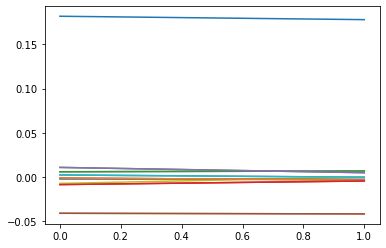

In [ ]:
params = {
"N_sw_measure" : 10,
"N_warm_up" : 10 // 5,
"N_from_scratch" : 10,
"N_qr" : 10,
"N_markov" : 2,
"chemical_potential" : 0,
"U" : 4,
"tunneling" : 1,
"periodic_Y" : 1,
"periodic_X" : 1,
"X_dimension" : 16,
"Y_dimension" : 8,
"N_s" : 16*8,
"N_time" : 100,
"Beta" : 4,                    
}
data = main(params)

In [ ]:
data["markov_data"]["correlations"]["szsz_mar"][0]

array([ 1.83623826, -0.40347365,  0.00765147, -0.00655064, -0.04591316,
        0.04891022, -0.00310778,  0.02715689,  0.03587883,  0.02715689,
       -0.00310778,  0.04891022, -0.04591316, -0.00655064,  0.00765147,
       -0.40347365])

In [ ]:
import pandas as pd
datalist = pd.read_csv(dir+"GPU doc - Sheet1.csv")
N_sw_measure = list(datalist['N_measurment'])
N_qr = list(datalist['N_qr'])
N_markov = list(datalist['N_markov'])
mu = list(datalist['mu'])
U = list(datalist['U'])
Beta = list(datalist['beta '])
N_x = list(datalist['N_x'])
N_y = list(datalist['N_y'])
N_time = list(datalist['N_time'])

for i in range(datalist.count()[0]):

    params = {
    "N_sw_measure" : N_sw_measure[i],
    "N_warm_up" : N_sw_measure[i] // 5,
    "N_from_scratch" : N_qr[i],
    "N_qr" : N_qr[i],
    "N_markov" : N_markov[i],
    "chemical_potential" : mu[i],
    "U" : U[i],
    "tunneling" : 1,
    "periodic_Y" : 1,
    "periodic_X" : 1,
    "X_dimension" : N_x[i],
    "Y_dimension" : N_y[i],
    "N_s" : N_x[i]*N_y[i],
    "N_time" : N_time[i],
    "Beta" : Beta[i],                    
    }
    name = "N_x:{} N_y:{} Beta:{} mu:{} N_time:{} U:{} N_sw_measure:{} N_qr:{} N_markov:{}".format(N_x[i],N_y[i],Beta[i],mu[i],N_time[i],U[i],N_sw_measure[i],N_qr[i],N_markov[i])
    data = main(params)
    save_obj(data, name)
    print(name)

 time: 346.6905691623688s
 kinetic_energy_mean: -1.385682269313956
 interaction_energy_mean: 0.20395221632096838
 n_mean: 0.6549744803695007
 mean_onsite_corr: 0.0018359537757224147
 energy_mean: -1.1817300529929877
 err_bar: 0.4179658347230077
 sign_mean: 0.984
N_x:4 N_y:4 Beta:4 mu:-1.8 N_time:40 U:4 N_sw_measure:1000 N_qr:10 N_markov:4
 time: 346.0346360206604s
 kinetic_energy_mean: -1.3104876549879219
 interaction_energy_mean: 0.50893532483517
 n_mean: 1.0
 mean_onsite_corr: 0.00403579785714208
 energy_mean: -0.801552330152752
 err_bar: 0.6552288771186909
 sign_mean: 1.0
N_x:4 N_y:4 Beta:4 mu:0.0 N_time:40 U:4 N_sw_measure:1000 N_qr:10 N_markov:4
 time: 1376.024540424347s
 kinetic_energy_mean: -1.314749631403091
 interaction_energy_mean: 0.5089337637075871
 n_mean: 1.0
 mean_onsite_corr: 0.008159726566224572
 energy_mean: -0.8058158676955038
 err_bar: 0.6958279761185783
 sign_mean: 1.0
N_x:4 N_y:4 Beta:4 mu:0.0 N_time:40 U:4 N_sw_measure:1000 N_qr:10 N_markov:16
 time: 174.32113409

In [ ]:
import glob
import csv

dirs = glob.glob("/content/drive/My Drive/scgpu/obj/*.pkl")
csv_columns = ['elpsd_time','kinetic_energy_mean', 'interaction_energy_mean', 'n_mean', 'mean_onsite_corr', 'energy_mean', 'err_bar', 'sign_mean']

    
try:
    with open(dir+"results.csv", 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        for d in dirs:
            data = load_obj(d)
            data = {key: value for key, value in data.items() if key in csv_columns}
            writer.writerow(data)
except IOError:
    print("I/O error")

In [ ]:
data.keys()

dict_keys(['elpsd_time', 'kinetic_energy_mean', 'interaction_energy_mean', 'n_mean', 'mean_onsite_corr', 'energy_mean', 'err_bar', 'sign_mean'])

In [ ]:
csv_columns = ['No','Country']
dict_data = [
{'No': 1, 'Name': 'Alex', 'Country': 'India'},
{'No': 2, 'Name': 'Ben', 'Country': 'USA'},
{'No': 3, 'Name': 'Shri Ram', 'Country': 'India'},
{'No': 4, 'Name': 'Smith', 'Country': 'USA'},
{'No': 5, 'Name': 'Yuva Raj', 'Country': 'India'},
]
csv_file = "Names.csv"
try:
    with open(csv_file, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        for data in dict_data:
            data = {key: value for key, value in data.items() if key in csv_columns}
            writer.writerow(data)
except IOError:
    print("I/O error")

In [ ]:
sign_partition_accu = cp.array([cp.linalg.slogdet(cp.random.normal(size=(10,10)))[0] for i in range(10)],dtype=cp.int32)

In [ ]:
sign_partition_accu[:,None]

array([[ 1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 1]], dtype=int32)

In [ ]:
m1 = main(1)
m10 = main(10)
10*m1/m10

2.963663339614868
-1.3457975854065565 0.9999999999933087
33.25367760658264
-1.4901133631829178 1.0000000011233912


0.8912287460885843

In [ ]:
m1 = main(1)
m10 = main(10)
10*m1/m10

4.512484073638916
-1.5510916287875727 1.0000000001013847
41.77274799346924
-1.6987394608727713 1.0000000001065275


1.080245923573043

In [ ]:
cupy.cuda.runtime.cudaDevAttrMaxThreadsPerBlock

1

In [ ]:
import cupy
cupy.cuda.runtime.deviceSetLimit(cupy.cuda.runtime.cudaLimitMallocHeapSize,2048*8388608)

In [ ]:
cupy.cuda.runtime.deviceGetLimit(cupy.cuda.runtime.cudaLimitMallocHeapSize)

17179869184

In [ ]:
import cupy
cupy.cuda.runtime.deviceGetLimit(cupy.cuda.runtime.cudaLimitMallocHeapSize)

8388608

In [ ]:
import matplotlib.pyplot as plt

strt = time.time()
mark_list = []
map_streams = []
for i in range(100):
    mark_list.append(i)
    map_streams.append(cp.cuda.stream.Stream())
ti = []
for j in range(1,10000,100):
    
    for (stream,i) in zip(map_streams,mark_list):
        with stream:
            for i in range(j):
                cp.random.normal(size=(10,10))
    cupy.cuda.Stream().synchronize()
    ti.append(time.time()-strt)
plt.plot(ti)
plt.plot(cp.asnumpy(cp.arange(100)))

KeyboardInterrupt: ignored

In [ ]:
!cuda-memcheck --tool racecheck python3 main.py

========= CUDA-MEMCHECK


KeyboardInterrupt: ignored

In [ ]:
!cuda-memcheck --leak-check full python3 main.py

========= CUDA-MEMCHECK
0.008235737696412192
0.007328857340110453
0.018367269033958696
0.018648878870509304
0.03718320728766194
0.04555422206976373
0.07098982365032536
0.38882843428519925
0.09998389193507595
0.17916067618277542
10
20.43350648880005
Traceback (most recent call last):
  File "main.py", line 618, in <module>
    main()
  File "main.py", line 616, in main
    print(cp.trace(cp.array(H_0).dot(cp.eye(2*N_s)-G_msr/N_measure))/N_s,np.trace(cp.eye(2*N_s) - G_msr/N_measure)/N_s)
ZeroDivisionError: division by zero
========= LEAK SUMMARY: 0 bytes leaked in 0 allocations
========= ERROR SUMMARY: 0 errors


In [ ]:
!cuda-memcheck --tool racecheck --racecheck-report analysis python3 main.py

========= CUDA-MEMCHECK
========= ERROR: Race reported between Write access at 0x00000ea0 in void larft_vtv_32<double, int=128>(int, int, double const *, unsigned long, double*, unsigned long)
=========     and Read access at 0x00000ed0 in void larft_vtv_32<double, int=128>(int, int, double const *, unsigned long, double*, unsigned long) [1562 hazards]
=========     and Write access at 0x00000ea0 in void larft_vtv_32<double, int=128>(int, int, double const *, unsigned long, double*, unsigned long) [19 hazards]
========= ERROR: Race reported between Write access at 0x00000ea0 in void larft_vtv_32<double, int=128>(int, int, double const *, unsigned long, double*, unsigned long)
=========     and Read access at 0x00000ed0 in void larft_vtv_32<double, int=128>(int, int, double const *, unsigned long, double*, unsigned long) [1562 hazards]
=========     and Write access at 0x00000ea0 in void larft_vtv_32<double, int=128>(int, int, double const *, unsigned long, double*, unsigned long) [19 h

In [ ]:
main()

In [ ]:
%lprun -f main main()

0.11459125215915683 1.0000000000000004


In [ ]:
If = cp.array([1],dtype=cp.float64)

In [ ]:
%prun If + hs[0,0]

In [ ]:
%lprun -f time_wrap time_wrap(G, Bk, Bk_inv, hs, cl, sign_U_interact,probability, gamma1, gamma2)

In [ ]:
%lprun -f update update(G, hs, N_s, probability_tmp, gamma1_tmp, gamma2_tmp,I)

In [ ]:
G, Bk, Bk_inv, hs, cl, sign_U_interact,probability, gamma1, gamma2 = time_wrap(G, Bk, Bk_inv, hs, cl, sign_U_interact,probability, gamma1, gamma2)

%lprun -f time_wrap  G, Bk, Bk_inv, hs, cl, sign_U_interact,probability, gamma1, gamma2 = time_wrap(G, Bk, Bk_inv, hs, cl, sign_U_interact,probability, gamma1, gamma2)


In [ ]:
np.trace(cp.eye(2*N_s) - G_msr/N_measure)/N_s

NameError: ignored

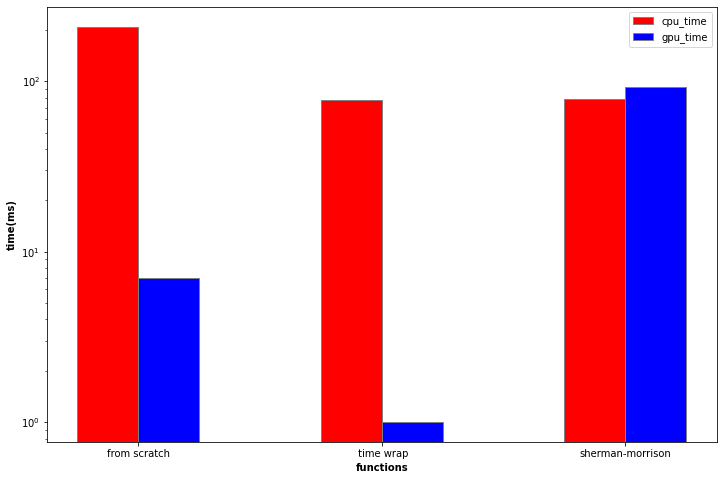

In [ ]:



import numpy as np 
import matplotlib.pyplot as plt 
   
# set width of bar 
barWidth = 0.25
fig, ax = plt.subplots(figsize =(12, 8)) 
   
# set height of bar 
name = ["from scratch", " time wrap", "sherman-morrison",]
cpu_time = [209,78,79]
gpu_time = [7,1,93]
   
# Set position of bar on X axis 
br1 = np.arange(3) 
br2 = [x + barWidth for x in br1] 
   
# Make the plot 
plt.bar(br1, cpu_time, color ='r', width = barWidth, 
        edgecolor ='grey', label ='cpu_time') 
plt.bar(br2, gpu_time, color ='b', width = barWidth, 
        edgecolor ='grey', label ='gpu_time') 
ax.set_yscale('log')
   
# Adding Xticks  
plt.xlabel('functions', fontweight ='bold') 
plt.ylabel('time(ms)', fontweight ='bold') 
plt.xticks([r + barWidth/2 for r in range(len(cpu_time))], 
           name) 
   
plt.legend() 


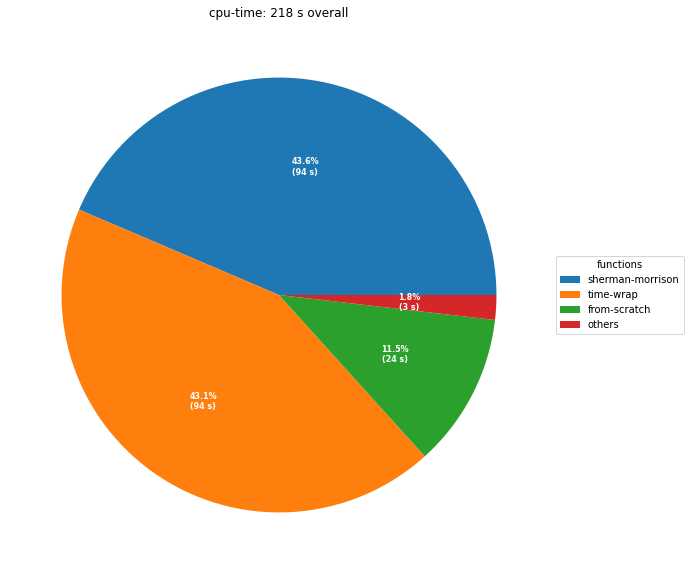

In [ ]:

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(aspect="equal"))

recipe = ["95 s sherman-morrison",
          "94 s time-wrap",
          "25 s from-scratch",
          "4 s others"]

data = [float(x.split()[0]) for x in recipe]
ingredients = [x.split()[-1] for x in recipe]


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} s)".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, ingredients,
          title="functions",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("cpu-time: 218 s overall")

plt.show()

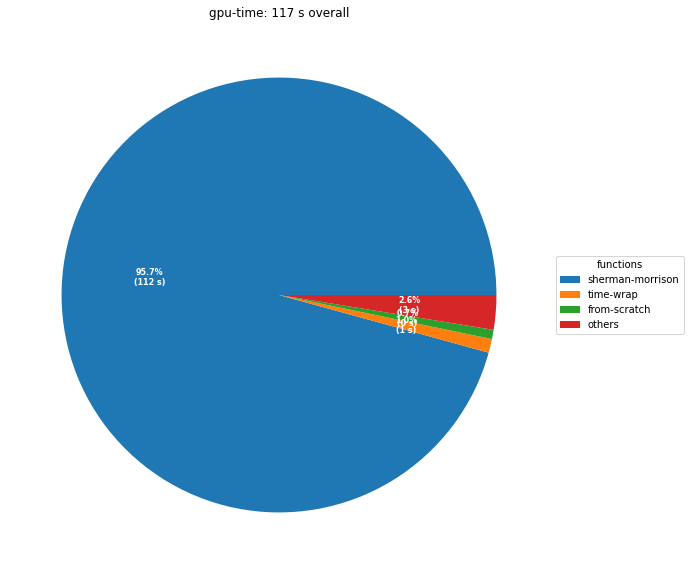

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(aspect="equal"))

recipe = ["112 s sherman-morrison",
          "1.2 s time-wrap",
          "0.8 s from-scratch",
          "3 s others"]

data = [float(x.split()[0]) for x in recipe]
ingredients = [x.split()[-1] for x in recipe]


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} s)".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, ingredients,
          title="functions",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("gpu-time: 117 s overall")

plt.show()

In [ ]:
Beta = 1
N_time = 10
N_s = 10

H_0 = make_hopping(10, 1, 1, 1, 1)
H_0_measure = H_0.copy()
H_0 += np.identity(10 * 1) * ((-1) * 0)
H_0 = np.kron(np.array([[1, 0], [0, 1]]), H_0) 


T_hop = np.concatenate(([1], np.ones(N_time-1))) * (Beta / N_time)
U_interact = 1 * np.ones(N_time)
sign_U_interact = np.array(np.sign(U_interact))
T_u = np.concatenate(([1], np.ones(N_time - 2), [1])) * (Beta / N_time)
H0_array = np.array([H_0 for i in range(N_time)])
lamda = np.arccosh(np.exp(np.abs(U_interact)*T_u/2))
probability = cp.array(np.exp(-(1 - np.sign(U_interact)) * lamda))
gamma1 = cp.array(np.exp(-2*lamda)-1)
gamma2 = cp.array(np.exp( 2*lamda*sign_U_interact)-1)


hs = lamda[:,None]*((-1)**cp.random.randint(2,size=(N_time,N_s)))
Bk, Bk_inv = expmk(H0_array.copy(), T_hop.copy())
cl = cluster(hs.copy(),Bk.copy(),sign_U_interact.copy())
G = from_scratch(cl.copy(),1)
I = 1
probability_tmp = probability[-1].copy()
gamma1_tmp = gamma1[-1].copy()
gamma2_tmp = gamma2[-1].copy()
G_sher, hs_new, sign_tmp = update(G.copy(), hs.copy(), N_s, probability_tmp, gamma1_tmp, gamma2_tmp)
cl2 = cluster(hs_new.copy(),Bk.copy(),sign_U_interact.copy())
G_f = from_scratch(cl2.copy(),1)
print(np.mean(2* cp.isclose(G_sher,G_f)),hs.shape)
sign_partition_accu = I
for i in range(1):
    # acceptance ratio
    if hs[-1,i]<0:
        gamma1_tmp, gamma2_tmp = gamma2_tmp, gamma1_tmp

    P = (probability_tmp if hs[-1,i]>0 else 1/probability_tmp)
    r_1 = (I + gamma1_tmp*(I-G[i,i]))
    alpha = G[i+N_s,i+N_s] + gamma1_tmp * G[i+N_s,i] * G[i,i+N_s] / r_1
    r_2 = I + gamma2_tmp*(I-alpha)
    r = r_1 * r_2 * P
    # if cp.abs(r) > cp.random.random():
    # update greens 
    k_1 = -G[:,i][:,None]
    k_1[i] += I
    G_1 = G - (gamma1_tmp / r_1) * (k_1*G[i,:])
    k_2 = -G_1[:,i+N_s][:,None]
    k_2[i+N_s] += I
    G = G_1 - (gamma2_tmp / r_2) * (k_2*G_1[i+N_s,:])
    # sign_partition_accu = cp.sign(r) *sign_partition_accu
        # hs[-1,i] = -hs[-1,i].copy()


2.0 (10, 10)


In [ ]:
type(G)

numpy.ndarray

In [ ]:
import numpy as np
for i in range(10):
    G = np.random.normal(size=(10,10))
    e = np.eye(len(G)) 
    I = 1
    k_1 = -G[:,0][:,None]
    k_1[0] += 1
    G_1 = k_1*G[0,:]
    G_2 = np.outer((e - G)[:,0],G[0,:])
    print(np.mean(np.isclose(G_1,G_2)*1))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [ ]:
import numpy as np
hs = ((-1)**np.random.randint(2,size=(10, 10)))
hs

array([[ 1, -1, -1, -1, -1,  1,  1, -1,  1,  1],
       [-1,  1, -1, -1, -1,  1,  1,  1,  1,  1],
       [-1,  1, -1, -1,  1, -1, -1,  1,  1,  1],
       [-1,  1,  1,  1, -1,  1, -1, -1, -1,  1],
       [ 1, -1,  1,  1,  1, -1,  1,  1, -1,  1],
       [ 1, -1,  1, -1, -1,  1, -1,  1, -1,  1],
       [-1, -1,  1,  1,  1, -1,  1, -1,  1,  1],
       [-1, -1,  1, -1, -1, -1, -1, -1, -1, -1],
       [ 1, -1, -1, -1, -1,  1, -1,  1,  1, -1],
       [-1,  1,  1, -1,  1, -1,  1,  1, -1,  1]])

In [ ]:
np.isclose(Bk[5],expm(-H0_array[5]*T_hop[5]))*1

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
np.isclose(cl[0],Bk[0].dot(np.diag(np.exp(np.concatenate([hs[0,:],-hs[0,:]])))))*1

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
a = cl[0]
for i in range(1,len(cl)):
    a = a.dot(cl[i])
np.isclose(from_scratch(cl.copy(),1),np.linalg.inv(np.eye(len(a)) + a))*1

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
hs[-1,0]

0.31886946750622885

In [ ]:
hs[-1,0] = hs[-1,0].copy()
cl2 = cluster(hs.copy(),Bk.copy(),sign_U_interact.copy())
G_f = from_scratch(cl2.copy(),1)

In [ ]:
np.isclose(G_f,G)*1

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
def make_hopping(n_x, n_y, periodic_x, periodic_y, tunneling):
    hopping_matrix = np.zeros((n_y * n_x, n_y * n_x))
    if n_y == 1:
        periodic_y = 0
    if n_x == 1:
        periodic_x = 0
 
    if n_x == 2:
        periodic_x = 1
    if n_y == 2:
        periodic_y = 1
 
    for j in range(n_x):
        for i in range(n_y):
            neighbour_1 = n_y * ((j + 1) % n_x) + i
            neighbour_2 = n_y * ((j - 1) % n_x) + i
            neighbour_3 = n_y * j + (i + 1) % n_y
            neighbour_4 = n_y * j + (i - 1) % n_y
 
            hopping_matrix[n_y * j + i][neighbour_1] = -1
            hopping_matrix[n_y * j + i][neighbour_2] = -1
            hopping_matrix[n_y * j + i][neighbour_3] = -1
            hopping_matrix[n_y * j + i][neighbour_4] = -1
 
            if i == 0:
                hopping_matrix[n_y * j + i][neighbour_4] *= periodic_y
            if i == n_y - 1:
                hopping_matrix[n_y * j + i][neighbour_3] *= periodic_y
            if j == 0:
                hopping_matrix[n_y * j + i][neighbour_2] *= periodic_x
            if j == n_x - 1:
                hopping_matrix[n_y * j + i][neighbour_1] *= periodic_x
 
    hopping_matrix *= tunneling
    return hopping_matrix
 
 
def QR(z,I):
    Q = I
    D = cp.diag(I)
    T = I
 
    for i in range(len(z)):
        A = (z[len(z) - i - 1]).dot(Q*D)
        Q, R = cp.linalg.qr(A)
        D = cp.diag(R)
        T_prime = R / D[:,None]
        T = T_prime.dot(T)
 
    return Q, D, T
 
 
 
def QR_prime(z, n):
    len_z,len_z0,_ = z.shape
    m = len_z // n
    if len_z % n != 0:
        m += 1
    z_0 = cp.empty((m,len_z0,len_z0))
    A0 = cp.eye(len_z0)
    A = A0
    for i in range(len_z):
        A = A.dot(z[i])
        if i%n == n-1:
            z_0[int(i/n),...] = A
            A = A0
    if len(z) % n != 0:
        z_0[int(i/n),...] = A
    # print(z_0)
    usvh = QR(z_0.copy(),A0.copy())
 
    return usvh[0], usvh[1], usvh[2]
 
 
 
def invers(Q, D, T):
    D_p = cp.where(cp.abs(D)>1,1,D)
    D_m = cp.where(cp.abs(D)<1,1,D)
    A1 = cp.conj(Q.T)/D_p[:,None] + D_m[:,None]*T
    A2 = 1/D_p
    A3 = cp.conj(Q.T)
    g = (cp.linalg.inv(A1)*A2).dot(A3)
    
    return g
 
 
def update(G, hs, N_s, probability_tmp, gamma1_tmp, gamma2_tmp, I):
    sign_partition_accu = I
    for i in range(N_s):
        # acceptance ratio
        if hs[-1,i]<0:
            gamma1_tmp, gamma2_tmp = gamma2_tmp, gamma1_tmp
 
        P = (probability_tmp if hs[-1,i]>0 else 1/probability_tmp)
        r_1 = (I + gamma1_tmp*(I-G[i,i]))
        alpha = G[i+N_s,i+N_s] + gamma1_tmp * G[i+N_s,i] * G[i,i+N_s] / r_1
        r_2 = I + gamma2_tmp*(I-alpha)
        r = r_1 * r_2 * P
        if cp.abs(r) > cp.random.random():
        # update greens 
            k_1 = -G[:,i][:,None]
            k_1[i] += I
            G_1 = G - (gamma1_tmp / r_1) * (k_1*G[i,:])
            k_2 = -G_1[:,i+N_s][:,None]
            k_2[i+N_s] += I
            G = G_1 - (gamma2_tmp / r_2) * (k_2*G_1[i+N_s,:])
            sign_partition_accu = cp.sign(r) *sign_partition_accu
            hs[-1,i] = -hs[-1,i]
 
    return G, hs, sign_partition_accu
 
def time_wrap(G, Bk, Bk_inv, h, cl, sign_U_interact,probability, gamma1, gamma2):
    B = Bk[-1].dot(cp.diag(cp.exp(cp.concatenate([h[-1,:],-sign_U_interact[-1]*h[-1,:]]))))
    B_inv = cp.diag(cp.exp(-cp.concatenate([h[-1,:],-sign_U_interact[-1]*h[-1,:]]))).dot(Bk_inv[-1])
    G = B.dot(G).dot(B_inv)
    cl[-1]= B
 
    h = cp.roll(h,1,axis = 0)
    Bk = cp.roll(Bk,1,axis = 0)
    Bk_inv = cp.roll(Bk_inv,1,axis = 0)
    cl = cp.roll(cl,1,axis = 0)
    probability = cp.roll(probability,1,axis = 0)
    gamma1 = cp.roll(gamma1,1,axis = 0)
    gamma2 = cp.roll(gamma2,1,axis = 0)
    sign_U_interact = cp.roll(sign_U_interact,1,axis = 0)
    return G, Bk, Bk_inv, h, cl, sign_U_interact, probability, gamma1, gamma2
 
def cluster(h,Bk,sign_U_interact):
    cl = []
    for i in range(h.shape[0]):
        cl.append(Bk[i].dot(cp.diag(cp.exp(cp.concatenate([h[i,:],-sign_U_interact[i]*h[i,:]])))))
    cl = cp.array(cl)
    return cl
 
def init_trotter(Beta,N_time,U_eff,H0):
    T_hop = np.concatenate(([1], np.ones(N_time-1))) * (Beta / N_time)
    U_interact = U_eff * np.ones(N_time)
    sign_U_interact = np.array(np.sign(U_interact))
    T_u = np.concatenate(([1], np.ones(N_time - 2), [1])) * (Beta / N_time)
    H0_array = np.array([H0 for i in range(N_time)])
    lamda = np.arccosh(np.exp(np.abs(U_interact)*T_u/2))
    probability = cp.array(np.exp(-(1 - np.sign(U_interact)) * lamda))
    gamma1 = cp.array(np.exp(-2*lamda)-1)
    gamma2 = cp.array(np.exp( 2*lamda*sign_U_interact)-1)
    return cp.array(sign_U_interact), T_hop, H0_array, cp.array(lamda), probability, gamma1, gamma2
 
def expmk(H0_array, T_hop): #cpu
    Bk = []
    Bk_inv = []
    for i in range(len(T_hop)):
        Bk.append(expm(-H0_array[i]*T_hop[i]))
        Bk_inv.append(expm(H0_array[i]*T_hop[i]))
    Bk = cp.array(Bk)
    Bk_inv = cp.array(Bk_inv)
    return Bk, Bk_inv
 
 
def from_scratch(cl,n_qr):
    Q,D,T = QR_prime(cl.copy(), n_qr)
    G = invers(Q, D, T)
    return G
 
def main():
 
    pass
def measure():
    pass

In [ ]:
# Set model.
X_dimension = 10
Y_dimension = 1
N_s = X_dimension * Y_dimension 
periodic_X = 1
periodic_Y = 1
tunneling = 1
U = 4
chemical_potential = 0  # half filling 0
n_markov = 1
N_sw_measure = 1
N_warm_up = N_sw_measure // 5
N_from_scratch = 10
N_qr = 10  # default = 2 * N_from_scratch
# type_of_mul = 1  # 1 = svd  ,0 = QR
# done
 
# Set generalized trotter
Beta = 2
N_time = 10
U_eff =  U
 
# making tunneling Hamiltonian matrix
H_0 = make_hopping(X_dimension, Y_dimension, periodic_X, periodic_Y, tunneling)
H_0_measure = H_0.copy()
H_0 += np.identity(X_dimension * Y_dimension) * ((-1) * chemical_potential)
H_0 = np.kron(np.array([[1, 0], [0, 1]]), H_0) 
 
filling_mar = cp.zeros(n_markov)
kinetic_mar = cp.zeros(n_markov)
interaction_mar = cp.zeros(n_markov)
sign_mar = cp.zeros(n_markov)
I = cp.array(1)
sign_U_interact, T_hop, H0_array, lamda, probability, gamma1, gamma2 = init_trotter(Beta,N_time,U_eff,H_0)
Bk, Bk_inv = expmk(H0_array.copy(), T_hop.copy())
for markov in range(n_markov):
    
    hs = lamda[:,None]*((-1)**cp.random.randint(2,size=(N_time,N_s)))
    cl = cluster(hs.copy(),Bk.copy(),sign_U_interact.copy())
    G = from_scratch(cl.copy(),N_qr)
#    print(G[0,0],"clus")
    G_msr = 0
    sign = 0
    N_measure = 0
    for msr in range(N_sw_measure+N_warm_up):
        print(msr)
        for l in range(N_time):
 
            probability_tmp = probability[-1].copy()
            gamma1_tmp = gamma1[-1].copy()
            gamma2_tmp = gamma2[-1].copy()
            G, hs, sign_tmp = update(G.copy(), hs.copy(), N_s, probability_tmp, gamma1_tmp, gamma2_tmp, I)
            cl = cluster(hs.copy(),Bk.copy(),sign_U_interact.copy())
            G_f = from_scratch(cl.copy(),N_qr)
            print(2* cp.isclose(G,G_f))
            G, Bk, Bk_inv, hs, cl, sign_U_interact,probability, gamma1, gamma2 = time_wrap(G.copy(), Bk.copy(), Bk_inv.copy(), hs.copy(), cl.copy(), sign_U_interact.copy(),probability.copy(), gamma1.copy(), gamma2.copy())

            if l%N_from_scratch == 0:
                G = from_scratch(cl.copy(),N_qr)
        if msr> N_warm_up:
            N_measure +=1
            G_msr += G

0
[[0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2]
 [0 0 0 

In [ ]:
def main():
        # Set model.
    X_dimension = 10
    Y_dimension = 10
    N_s = X_dimension * Y_dimension 
    periodic_X = 1
    periodic_Y = 1
    tunneling = 1
    U = 4
    chemical_potential = 0  # half filling 0
    n_markov = 1
    N_sw_measure = 100
    N_warm_up = N_sw_measure // 5
    N_from_scratch = 10
    N_qr = 10  # default = 2 * N_from_scratch
    # type_of_mul = 1  # 1 = svd  ,0 = QR
    # done
    
    # Set generalized trotter
    Beta = 2
    N_time = 10
    U_eff =  U
    
    # making tunneling Hamiltonian matrix
    H_0 = make_hopping(X_dimension, Y_dimension, periodic_X, periodic_Y, tunneling)
    H_0_measure = H_0.copy()
    H_0 += np.identity(X_dimension * Y_dimension) * ((-1) * chemical_potential)
    H_0 = np.kron(np.array([[1, 0], [0, 1]]), H_0) 
    
    filling_mar = cp.zeros(n_markov)
    kinetic_mar = cp.zeros(n_markov)
    interaction_mar = cp.zeros(n_markov)
    sign_mar = cp.zeros(n_markov)
    I = cp.array(1)
    sign_U_interact, T_hop, H0_array, lamda, probability, gamma1, gamma2 = init_trotter(Beta,N_time,U_eff,H_0)
    Bk, Bk_inv = expmk(H0_array, T_hop)
    for markov in range(n_markov):
        
        hs = lamda[:,None]*((-1)**cp.random.randint(2,size=(N_time+1,N_s)))
        cl = cluster(hs,Bk,sign_U_interact)
        G = from_scratch(cl,N_qr)
    #    print(G[0,0],"clus")
        G_msr = 0
        sign = 0
        N_measure = 0
        for msr in range(N_sw_measure+N_warm_up):
            # print(msr)
            for l in range(N_time):
    
                probability_tmp = probability[-1]
                gamma1_tmp = gamma1[-1]
                gamma2_tmp = gamma2[-1]
                G, hs, sign_tmp = update(G, hs, N_s, probability_tmp, gamma1_tmp, gamma2_tmp, I)
                G, Bk, Bk_inv, hs, cl, sign_U_interact,probability, gamma1, gamma2 = time_wrap(G, Bk, Bk_inv, hs, cl, sign_U_interact,probability, gamma1, gamma2)
                # cl = cluster(hs,Bk,sign_U_interact)
                # G_f = from_scratch(cl,N_qr)
                # print(2* cp.isclose(G,G_f))
                # time.sleep(10)
                if l%N_from_scratch == 0:
                    G = from_scratch(cl,N_qr)
            if msr> N_warm_up:
                N_measure +=1
                G_msr += G

In [ ]:
%timeit main()

1 loop, best of 3: 49.1 s per loop


In [ ]:
%timeit update(G, hs, N_s, probability_tmp, gamma1_tmp, gamma2_tmp, I)

10 loops, best of 3: 164 ms per loop


In [ ]:
%timeit from_scratch(cl,N_qr)

10 loops, best of 3: 88.4 ms per loop


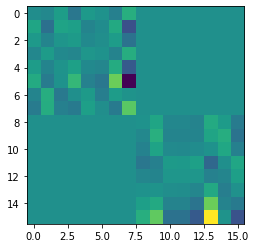

In [ ]:
G_f = from_scratch(cl,N_qr)
plt.imshow(cp.asnumpy(G_f-G))

0.4999999999999998
0.5000975670787858
0.5002601312784787
0.5003137339869166
0.5002639048025794
0.5003330601596764
0.500289273613383
0.5001263265535454
0.5003986306023048
0.5001877417792882
0.5004461543273578
0.5002687983730278
0.5004053058458962
0.5003169717993569
0.5004123127751307
0.5003565663825401
0.5002225568302694
0.5003446983831921
0.5004230977900321
0.5003151097873396
0.5003914797906556
0.5004035587371516
0.5000382260383494
0.5000918886951291
0.5004143497301936
0.5002955965981911
0.5002367493646935
0.5002153259089613
0.5001679646675324
0.5003984601324588
0.5002650460122063
0.5003378033482226
0.5002066003970472
0.5002415517719391
0.5003025719413867
0.5002408363650569
0.5002140884756265
0.5003599926361542
0.500254276561793
0.5002860353841679
0.50024772529851
0.500275230184205
0.500478963926223
0.5003776930423062
0.5002774988823355
0.5003691236943756
0.5000969111800816
0.5002671509056503
0.5003666464262461
0.500359181602121
0.5004068252116567
0.5003204684804053
0.5003239603748844


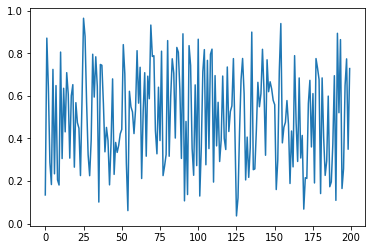

In [ ]:
# def update(G, hs, N_s, probability_tmp, gamma1_tmp, gamma2_tmp, I):
import time
sign_U_interact, T_hop, H0_array, lamda, probability, gamma1, gamma2 = init_trotter(Beta,N_time,U_eff,H_0)
probability_tmp = probability[-1]
gamma1_tmp = gamma1[-1]
gamma2_tmp = gamma2[-1]
sign_partition_accu = I
hs = lamda[:,None]*((-1)**cp.random.randint(2,size=(N_time+1,N_s)))
cl = cluster(hs,Bk,sign_U_interact)
G = from_scratch(cl,N_qr)
plt.plot(cp.asnumpy(cp.diag(G)))
print(cp.trace(G)/200)
sign_partition_accu = I
for i in range(N_s):
    # acceptance ratio
    P = (probability_tmp if hs[-1,i]>0 else 1/probability_tmp)
    r_1 = (I + gamma1_tmp*(I-G[i,i]))
    alpha = G[i+N_s,i+N_s] + gamma1_tmp * G[i+N_s,i] * G[i,i+N_s] / r_1
    r_2 = I + gamma2_tmp*(I-alpha)
    r = r_1 * r_2 * P
    if cp.abs(r) > cp.random.random():
    # update greens 
        k_1 = -G[:,i][:,None]
        k_1[i] += I
        G_1 = G - (gamma1_tmp / r_1) * (k_1*G[i,:])
        k_2 = -G_1[:,i+N_s][:,None]
        k_2[i+N_s] += I
        G = G_1 - (gamma2_tmp / r_2) * (k_2*G_1[i+N_s,:])
        print(cp.trace(G_1)/200)
        sign_partition_accu = cp.sign(r) *sign_partition_accu
        hs[-1,i] = -hs[-1,i]


In [ ]:
gamma1_tmp,gamma2_tmp

(array(-0.63975023), array(1.7758519))

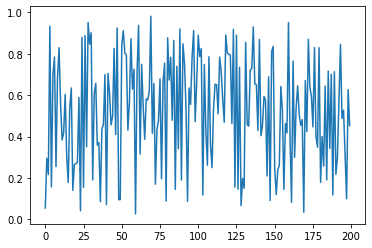

In [ ]:
plt.plot(cp.asnumpy(cp.diag(G)))

In [ ]:
cp.trace(G)/16

array(0.51748253)

In [ ]:
def QR(z,I):
    Q = I
    D = cp.diag(I)
    T = I
 
    for i in range(len(z)):
        A = (z[len(z) - i - 1]).dot(Q*D)
        Q, R = cp.linalg.qr(A)
        D = cp.diag(R)
        T_prime = R / D[:,None]
        T = T_prime.dot(T)
 
    return Q, D, T
 
 
 
def QR_prime(z, n):
    len_z,len_z0,_ = z.shape
    m = len_z // n
    if len_z % n != 0:
        m += 1
    z_0 = cp.empty((m,len_z0,len_z0))
    A0 = cp.eye(len_z0)
    A = A0
    for i in range(len_z):
        A = A.dot(z[i])
        if i%n == n-1:
            z_0[int(i/n),...] = A
            A = A0
    if len(z) % n != 0:
        z_0[int(i/n),...] = A
    # print(z_0)
    usvh = QR(z_0,A0)
 
    return usvh[0], usvh[1], usvh[2]
 
 
 
def invers(Q, D, T):
    D_p = cp.where(cp.abs(D)>1,1,D)
    D_m = cp.where(cp.abs(D)<1,1,D)
    A1 = cp.conj(Q.T)/D_p[:,None] + D_m[:,None]*T
    A2 = 1/D_p
    A3 = cp.conj(Q.T)
    g = (cp.linalg.inv(A1)*A2).dot(A3)
    
    return g

def from_scratch(cl,n_qr):
    Q,D,T = QR_prime(cl, n_qr)
    G = invers(Q, D, T)
    return G

def cluster(h,Bk,sign_U_interact):
    cl = []
    for i in range(h.shape[0]):
        cl.append(Bk[i].dot(cp.diag(cp.exp(cp.concatenate([h[i,:],-sign_U_interact[i]*h[i,:]])))))
    cl = cp.array(cl)
    return cl
 
def update(G, hs, N_s, probability_tmp, gamma1_tmp, gamma2_tmp, I):
    sign_partition_accu = I
        # acceptance ratio
    i = 1
    if hs[-1,i]<0:
        gamma1_tmp, gamma2_tmp = gamma2_tmp, gamma1_tmp

    P = (probability_tmp if hs[-1,i]>0 else 1/probability_tmp)
    r_1 = (I + gamma1_tmp*(I-G[i,i]))
    alpha = G[i+N_s,i+N_s] + gamma1_tmp * G[i+N_s,i] * G[i,i+N_s] / r_1
    r_2 = I + gamma2_tmp*(I-alpha)
    r = r_1 * r_2 * P
    if cp.abs(r) > 0:
    # update greens 
        k_1 = -G[:,i][:,None]
        k_1[i] += I
        G_1 = G - (gamma1_tmp / r_1) * (k_1*G[i,:])
        k_2 = -G_1[:,i+N_s][:,None]
        k_2[i+N_s] += I
        G = G_1 - (gamma2_tmp / r_2) * (k_2*G_1[i+N_s,:])
        sign_partition_accu = cp.sign(r) *sign_partition_accu
        # hs[-1,i] = -hs[-1,i]
 
    return G, hs, sign_partition_accu

In [ ]:
import cupy as cp
 
lamda = 0.5


Bk = cp.random.normal(size= (6,6))
B0 = Bk.dot(cp.diag(cp.exp(lamda * cp.array([-1,-1,-1,1,1,1]))))
B1 = Bk.dot(cp.diag(cp.exp(lamda * cp.array([1,1,-1,-1,-1,1]))))
B2 = Bk.dot(cp.diag(cp.exp(lamda * cp.array([-1,-1,-1,1,1,1]))))
B2_0 = Bk.dot(cp.diag(cp.exp(lamda * cp.array([-1,1,-1,1,1,1]))))
B2_1 = Bk.dot(cp.diag(cp.exp(lamda * cp.array([-1,1,-1,1,-1,1]))))
hs_old = lamda * cp.array([cp.array([-1,-1,-1]),cp.array([1,1,-1]),cp.array([-1,-1,-1])])
hs = lamda * cp.array([cp.array([-1,-1,-1]),cp.array([1,1,-1]),cp.array([-1,1,-1])])

cl = cluster(hs,cp.array([Bk,Bk,Bk]),cp.array([1,1,1]))

g = from_scratch(cl,2)


G = cp.linalg.inv(cp.eye(6) + B0.dot(B1.dot(B2)))
G_0 = cp.linalg.inv(cp.eye(6) + B0.dot(B1.dot(B2_0)))
G_new = cp.linalg.inv(cp.eye(6) + B0.dot(B1.dot(B2_1)))

In [ ]:
cp.isclose(cl,cp.array([B0,B1,B2_1]))

array([[[ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True]]])

In [ ]:
cp.isclose(g,G_new)

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

In [ ]:
# %%debug
# def update(G, hs, N_s, probability_tmp, gamma1_tmp, gamma2_tmp, I):
gamma1 = cp.array(cp.exp(-2*lamda)-1)
gamma2 = cp.array(cp.exp(2*lamda)-1)
I =1
gamma1_tmp = gamma1
gamma2_tmp = gamma2
probability_tmp = 1

N_s = 3
sign_partition_accu = I
    # acceptance ratio
i =1
if hs_old[-1,i]<0:
    print("8")
    gamma1_tmp, gamma2_tmp = gamma2_tmp, gamma1_tmp

P = (probability_tmp if hs_old[-1,i]>0 else 1/probability_tmp)
r_1 = (I + gamma1_tmp*(I-G[i,i]))
alpha = G[i+N_s,i+N_s] + gamma1_tmp * G[i+N_s,i] * G[i,i+N_s] / r_1
r_2 = I + gamma2_tmp*(I-alpha)
r = r_1 * r_2 * P
# if cp.abs(r) > 0:
# update greens 
k_1 = -G[:,i][:,None]
k_1[i] += I
G_1 = G - (gamma1_tmp / r_1) * (k_1*G[i,:])
k_2 = -G_1[:,i+N_s][:,None]
k_2[i+N_s] += I
G_sher = G_1 - (gamma2_tmp / r_2) * (k_2*G_1[i+N_s,:])
# sign_partition_accu = cp.sign(r) *sign_partition_accu
# hs_old[-1,i] = -hs_old[-1,i]
 
    # return G, hs, sign_partition_accu
 

8


In [ ]:
cp.isclose(G_sher,g)

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

In [ ]:
gamma1 = cp.array(cp.exp(-2*lamda)-1)
gamma2 = cp.array(cp.exp(2*lamda)-1)
G_sher,_,_ = update(G,hs_old,3,1,gamma1,gamma2,1)

In [ ]:
cp.isclose(G_sher,g)

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

In [ ]:
cp.trace(G_sher)

array(4.11350428)

In [ ]:
N_s = 3
I =1
i = 2
r_1 = (I + gamma1*(I-G[i,i]))
alpha = G[i+N_s,i+N_s] + gamma1 * G[i+N_s,i] * G[i,i+N_s] / r_1
r_2 = I + gamma2*(I-alpha)


k_1 = -G[:,i][:,None]
k_1[i] += I
G_1 = G - (gamma1 / r_1) * (k_1*G[i,:])
k_2 = -G_1[:,i+N_s][:,None]
k_2[i+N_s] += I
G_sher = G_1 - (gamma2 / r_2) * (k_2*G_1[i+N_s,:])


In [ ]:
N_s = 3
I =1
i = 3
r_1 = (I + gamma2*(I-G[i,i]))


G_1 = G - (gamma2 / r_1) * cp.outer((cp.eye(6)-G)[:,i],G[i,:])



(array([[ 0.36597629, -0.16047024,  0.36902856, -0.84958411,  0.24657736,
         -0.85117425],
        [-0.10542338, -0.3803568 ,  0.37011512, -1.23441354, -0.37688386,
         -1.07904496],
        [ 0.15057617,  0.39254327, -0.10309857,  1.28010768, -0.06486296,
          0.7984074 ],
        [-1.98550329,  0.94177423,  0.11111417, -1.70273121,  1.07132597,
          1.70400628],
        [-1.59726558, -0.74083006,  1.09785817, -2.96619483,  0.80260161,
         -0.38950102],
        [-0.2361974 ,  0.06778141, -0.07746467,  0.22771516,  0.28626394,
          0.903608  ]]),
 array([[ 0.36597629, -0.16047024,  0.36902856, -0.84958411,  0.24657736,
         -0.85117425],
        [-0.10542338, -0.3803568 ,  0.37011512, -1.23441354, -0.37688386,
         -1.07904496],
        [ 0.15057617,  0.39254327, -0.10309857,  1.28010768, -0.06486296,
          0.7984074 ],
        [-1.98550329,  0.94177423,  0.11111417, -1.70273121,  1.07132597,
          1.70400628],
        [-1.59726558, -0.740

In [ ]:
index = cp.array(list(range(4)))
indexp = cp.roll(index,1)

In [ ]:
index,indexp

(array([0, 1, 2, 3]), array([3, 0, 1, 2]))

In [ ]:
%%timeit 

h[indexp]
G[indexp]
G[indexp]

1000 loops, best of 3: 2.15 ms per loop


In [ ]:

cp.roll(h,-1,axis=0)[0],h[1]


(array([[[ 0.20291433],
         [-0.66918769]],
 
        [[ 0.58185911],
         [-0.73547444]]]), array([[[ 0.20291433],
         [-0.66918769]],
 
        [[ 0.58185911],
         [-0.73547444]]]))

In [ ]:
one = cp.asarray(1.0)
alpha = G[0,0] + I
beta = 1

In [ ]:
%timeit beta + I
II = cp.int(1)
%timeit I + II
%timeit I + 1.0

The slowest run took 9.51 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 41.9 µs per loop
10000 loops, best of 3: 26.7 µs per loop
10000 loops, best of 3: 25.8 µs per loop


In [ ]:
G[0,0],alpha,I.device,I+II

(array(0.52252296), array(1.52252296), <CUDA Device 0>, array(2.))

In [ ]:
%lprun -f update update(G,h,128,I,I,I)

In [ ]:
np.

In [ ]:
%%timeit
for i in range(30):
    g,hh = update(G,h,128,1,1)
    # g = cp.asarray(g)
    # hh = cp.asarray(hh)

TypingError: ignored

In [ ]:
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32

In [ ]:
from __future__ import print_function, absolute_import

from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import numpy as np

@cuda.jit
def compute_pi(rng_states, iterations, out):
    """Find the maximum value in values and store in result[0]"""
    thread_id = cuda.grid(1)

    # Compute pi by drawing random (x, y) points and finding what
    # fraction lie inside a unit circle
    inside = 0
    for i in range(iterations):
        x = xoroshiro128p_uniform_float32(rng_states, thread_id)
        y = xoroshiro128p_uniform_float32(rng_states, thread_id)
        if x**2 + y**2 <= 1.0:
            inside += 1

    out[thread_id] = 4.0 * inside / iterations

threads_per_block = 64
blocks = 24
rng_states = create_xoroshiro128p_states(threads_per_block * blocks, seed=1)
out = np.zeros(threads_per_block * blocks, dtype=np.float32)

compute_pi[blocks, threads_per_block](rng_states, 100000000, out)
print('pi:', out.mean())


pi: 3.1415894


In [ ]:
1000000*10/3600/24/30

3.858024691358025

In [ ]:
def test(G):
    G[i+128,i+128] 
    1 * G[i+128,i] * G[i,i+128] 
    1-G[i,i]
    1-2
    a = G[i,i]
    G[i,i]
    1-a

In [ ]:
G = np.random.normal(size=(256,256))
%lprun -f test test(G)

In [ ]:
a = cp.random.normal(size=(30,256,256))
b = cp.asnumpy(a)

In [ ]:
%timeit QR_prime(b,10)

10 loops, best of 3: 56.6 ms per loop


In [ ]:
%timeit QR_prime2(a,10)

10 loops, best of 3: 17.6 ms per loop


In [ ]:
%lprun -f QR QR(b)

In [ ]:
I = cp.eye(len(a[0]))
%lprun -f QR2 QR2(a,I)

In [ ]:
Q1,D1,T1 = QR(b)

In [ ]:
Q2,D2,T2 = QR2(a,I)

In [ ]:
g1 = invers(Q1,D1,T1)

10 loops, best of 3: 52.6 ms per loop


In [ ]:
g2 = invers2(Q2,D2,T2)

In [ ]:
np.isclose(g1,cp.asnumpy(g2))

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [ ]:
g1

array([[ 0.08069409, -0.34624383, -0.14043474, ..., -0.09710991,
        -0.08077082, -0.0762052 ],
       [-0.07961458,  0.34078457,  0.13815014, ...,  0.09556778,
         0.0796993 ,  0.07510105],
       [ 0.17334411, -0.74328726, -0.30144608, ..., -0.2084629 ,
        -0.17349993, -0.16364319],
       ...,
       [ 0.12159123, -0.52163127, -0.21157225, ..., -0.1463003 ,
        -0.12169891, -0.11481339],
       [-0.08223615,  0.35320466,  0.14330137, ...,  0.09906876,
         0.0822972 ,  0.07769048],
       [ 0.04013221, -0.1711738 , -0.06934522, ..., -0.04799572,
        -0.04017664, -0.03779238]])

In [ ]:
g2

array([[ 0.08069409, -0.34624383, -0.14043474, ..., -0.09710991,
        -0.08077082, -0.0762052 ],
       [-0.07961458,  0.34078457,  0.13815014, ...,  0.09556778,
         0.0796993 ,  0.07510105],
       [ 0.17334411, -0.74328726, -0.30144608, ..., -0.2084629 ,
        -0.17349993, -0.16364319],
       ...,
       [ 0.12159123, -0.52163127, -0.21157225, ..., -0.1463003 ,
        -0.12169891, -0.11481339],
       [-0.08223615,  0.35320466,  0.14330137, ...,  0.09906876,
         0.0822972 ,  0.07769048],
       [ 0.04013221, -0.1711738 , -0.06934522, ..., -0.04799572,
        -0.04017664, -0.03779238]])

In [ ]:
np.max(Q1-cp.asnumpy(Q2))

6.014806708254383e-14

In [ ]:
np.isclose(D1,np.diag(cp.asnumpy(D2)))

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [ ]:
np.max(T1-cp.asnumpy(T2))

3.2880365097298636e-12

In [ ]:
D2

array([ 1.07384992e+36,  1.09819751e+36, -1.26512615e+36,  1.32223897e+36,
       -1.25922481e+36, -1.00151505e+36,  8.47926620e+35,  1.07296155e+36,
       -6.61013828e+35,  1.36882718e+36,  7.10816743e+35,  3.99909045e+35,
       -7.71049141e+35, -6.48919000e+35,  4.71907214e+35,  4.41789358e+35,
       -4.43333240e+35,  5.20271686e+35,  5.60688385e+35,  3.19461712e+35,
        4.79590422e+35, -4.24904424e+35,  3.56947968e+35,  2.43991626e+35,
        2.74854203e+35, -3.55829035e+35, -2.73351605e+35, -3.38482737e+35,
       -2.67919622e+35,  2.19847611e+35,  1.35799432e+35,  1.55505628e+35,
        2.03220716e+35,  1.35755368e+35, -1.74525434e+35, -1.28094149e+35,
       -1.01309161e+35, -1.42373079e+35,  8.81167661e+34, -1.61097664e+35,
        1.00973140e+35,  9.25674605e+34,  8.35789577e+34, -7.89386353e+34,
       -6.96719442e+34,  8.38272806e+34, -7.93278898e+34, -4.94780146e+34,
        4.10006217e+34, -5.66687847e+34, -4.15963293e+34, -2.65750139e+34,
        4.52694707e+34, -

In [ ]:
%timeit [np.linalg.qr(a[i]) for i in range(30)]

In [ ]:
%%prun
Q = I
D = I
T = I

for i in range(len(a)):
    A = (a[len(a) - i - 1]).dot(Q.dot(D))
    Q, R = cp.linalg.qr(A)

    T_prime = (cp.diag(1 / cp.diag(R))).dot(R)
    T = T_prime.dot(T)
    D = cp.diag(cp.diag(R))

In [ ]:
def qr(z):
    s = np.identity(len(z[0]))
    u = np.identity(len(z[0]))
    vh = np.identity(len(z[0]))

    for j in range(len(z)):
        u_1, s_1 = np.linalg.qr(z[j], full_matrices=True)
        s_1_diag = np.diag(s_1)
        a = np.matmul(s_1_diag, np.matmul(np.matmul(vh_1, u), s))
        u_2, s_2, vh_2 = np.linalg.qr(a, full_matrices=True)
        u = np.matmul(u_1, u_2)
        s_2_diag = np.diag(s_2)
        s = s_2_diag
        vh = np.matmul(vh_2, vh)

    return u, s, vh





In [ ]:
%timeit qr(a)

In [ ]:
x_cpu = b[0]
x_gpu = a[0]

%timeit np.linalg.qr(x_cpu)

%timeit cp.linalg.qr(x_gpu)


In [ ]:
x_gpud = cp.diag(x_gpu)

In [ ]:
aa = x_gpud[:,None]*x_gpu

In [ ]:
bb =  cp.diag(x_gpud).dot(x_gpu)

In [ ]:
np.isclose(aa,bb)

In [ ]:
sad = cp.random.normal(1,2,(1,10))

In [ ]:
sad2 = sad
sad2[sad<1] = 1 

In [ ]:
nnn

array([[4.0638364 , 2.08147052, 1.        , 1.        , 1.73449968,
        1.        , 2.0223453 , 1.71693217, 1.        , 1.        ]])

In [ ]:
sad2

array([[1.        , 1.        , 2.00357005, 2.29041817, 1.79996971,
        4.27379476, 1.        , 1.        , 4.78986567, 1.        ]])

In [ ]:
import numpy as np
k = np.array([[0,0,1,0]])
G = np.random.normal(size = (k.shape[1],k.shape[1]))

In [ ]:
kk = np.dot(k.T,k)

In [ ]:
%%timeit

k = np.array([[0,0,1,0]])
a = (np.eye(G.shape[0])-G).dot(np.dot(k.T,k)).dot(G)

The slowest run took 28.05 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 8.43 µs per loop


In [ ]:
%%timeit

b = np.outer((np.eye(G.shape[0]) - G)[:, 2], G[2, :])

The slowest run took 15.21 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 7.78 µs per loop


In [ ]:
G = cupy.asarray(G)
k = cupy.zeros(G.shape)

In [ ]:
%%timeit


k[:,2] = (cupy.eye(G.shape[0])-G)[:,2]
c = k.dot(G)

1000 loops, best of 3: 574 µs per loop


In [ ]:
c

array([[-0.171966  , -0.2483357 , -0.05883828, -0.2440736 ],
       [-0.58000409, -0.83758256, -0.1984488 , -0.82320743],
       [ 0.48749052,  0.70398392,  0.16679522,  0.6919017 ],
       [-0.58721316, -0.84799316, -0.20091539, -0.83343936]])

In [ ]:
c[1,:]/k[1,2],G[2,:]

(array([-1.64661502, -1.73992686,  1.08018836,  0.1163992 ]),
 array([-1.64661502, -1.73992686,  1.08018836,  0.1163992 ]))

In [ ]:
%%timeit
l = np.zeros((4,4))
for i in range(4):
    l[i,:] = (int(i==2)-G[i,2])*G[2,:]

The slowest run took 6.31 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 12 µs per loop


In [ ]:
%timeit (np.eye(G.shape[0])-G)[:,2][:,None]*G[2,:]

The slowest run took 10.28 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 4.78 µs per loop


In [ ]:
from numba import cuda,guvectorize
import cupy
@guvectorize(['void(float64[:,:],float64[:,:])'],'(m,n)->(m,n)')
def prod(G,l):
    for i in range(G.shape[0]):
        for j in range(G.shape[0]):
            l[i,j] = (int(i==3)-G[i,3])*G[3,j]

In [ ]:
@cupy.fuse()
def prod2(G1,G2):
    return G1*G2

In [ ]:
%%timeit 
k = -G[:,3][:,None]
k[3] += 1
prod2(k,G[3,:])

The slowest run took 7.64 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 71.3 µs per loop


In [ ]:
G =cupy.random.random(size=(200,200))


In [ ]:
%%timeit 
k = -G[:,3][:,None]
k[3] += 1
k*G[3,:]

The slowest run took 14.91 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 64.1 µs per loop


<function ndarray.put>

In [ ]:
%%timeit
l =np.empty_like(cupy.asnumpy(G))
prod(cupy.asnumpy(G),l)
t = cupy.asarray(l)

1000 loops, best of 3: 472 µs per loop


In [ ]:
t

array([[-0.19245095, -0.3872126 , -0.49078754, ..., -0.37337387,
        -0.47085559, -0.4539432 ],
       [-0.19849739, -0.39937807, -0.50620714, ..., -0.38510456,
        -0.48564896, -0.46820522],
       [-0.077481  , -0.15589228, -0.19759168, ..., -0.15032079,
        -0.18956705, -0.18275811],
       ...,
       [-0.31705423, -0.63791523, -0.80855026, ..., -0.61511656,
        -0.77571327, -0.74785088],
       [-0.1758216 , -0.35375422, -0.44837943, ..., -0.34111128,
        -0.43016976, -0.41471875],
       [-0.10525473, -0.21177323, -0.26842014, ..., -0.20420459,
        -0.25751901, -0.24826934]])

In [ ]:
import cupy

x = cupy.array([1, 3, 2])
expected = x.sort()
cupy.cuda.Device().synchronize()

stream = cupy.cuda.stream.Stream()
with stream:
    y = x.sort()
stream.synchronize()
cupy.testing.assert_array_equal(y, expected)

stream = cupy.cuda.stream.Stream()
stream.use()
y = x.sort()
stream.synchronize()
cupy.testing.assert_array_equal(y, expected)

In [ ]:
print(cupy.testing.assert_array_equal(y, expected))

None


In [ ]:
# nvprof --print-gpu-trace python examples/stream/cupy_memcpy.py
import cupy
import numpy

pinned_memory_pool = cupy.cuda.PinnedMemoryPool()
cupy.cuda.set_pinned_memory_allocator(pinned_memory_pool.malloc)


def _pin_memory(array):
    mem = cupy.cuda.alloc_pinned_memory(array.nbytes)
    ret = numpy.frombuffer(mem, array.dtype, array.size).reshape(array.shape)
    ret[...] = array
    return ret


SIZE = 1024 * 1024
x_cpu_src = numpy.arange(SIZE, dtype=numpy.float32)
x_gpu_src = cupy.arange(SIZE, dtype=numpy.float32)


# synchronous
stream = cupy.cuda.Stream.null
start = stream.record()
x_gpu_dst = cupy.empty(x_cpu_src.shape, x_cpu_src.dtype)
x_gpu_dst.set(x_cpu_src)
x_cpu_dst = x_gpu_src.get()
end = stream.record()

print('Synchronous Device to Host / Host to Device (ms)')
print(cupy.cuda.get_elapsed_time(start, end))


# asynchronous
x_gpu_dst = cupy.empty(x_cpu_src.shape, x_cpu_src.dtype)
x_cpu_dst = numpy.empty(x_gpu_src.shape, x_gpu_src.dtype)

x_pinned_cpu_src = _pin_memory(x_cpu_src)
x_pinned_cpu_dst = _pin_memory(x_cpu_dst)

with cupy.cuda.stream.Stream() as stream_htod:
    start = stream_htod.record()
    x_gpu_dst.set(x_pinned_cpu_src)
    with cupy.cuda.stream.Stream() as stream_dtoh:
        x_gpu_src.get(out=x_pinned_cpu_dst)
        stream_dtoh.synchronize()
    stream_htod.synchronize()
    end = stream_htod.record()

print('Asynchronous Device to Host / Host to Device (ms)')
print(cupy.cuda.get_elapsed_time(start, end))

Synchronous Device to Host / Host to Device (ms)
3.8452160358428955
Asynchronous Device to Host / Host to Device (ms)
0.5066879987716675


In [ ]:
# nvprof --print-gpu-trace python examples/stream/cublas.py
import cupy

x = cupy.random.normal(size=(1,10000))
y = cupy.random.normal(size=(10000,1))
expected = cupy.dot(y, x)
cupy.cuda.Device().synchronize()

stream = cupy.cuda.stream.Stream()
with stream as st:
    start = st.record()
    z = cupy.dot(y, x)

stream.synchronize()
end = st.record()
cupy.testing.assert_array_equal(z, expected)
print(cupy.cuda.get_elapsed_time(start, end))
# stream = cupy.cuda.stream.Stream()
# stream.use()
# z = cupy.dot(x, y)
# stream.synchronize()
# cupy.testing.assert_array_equal(z, expected)



5.220736026763916


In [ ]:
%time expected = cupy.dot(y, x)

CPU times: user 480 µs, sys: 1.9 ms, total: 2.38 ms
Wall time: 1.97 ms


In [ ]:
for nx_1 in range(N_x)
    for ny_1 in range(N_y)
        
        R1_0 = nx_1*N_y + ny_1 # first coordinate of the correlation function
        R2_0 = N_y*cp.concatenate([cp.arange(nx_1+1,N_x) ,cp.arange(0,nx_1+1)]) - N_y + ny_1  # 2nd coordinate of the correlation function
        
        
        # <sz(R1_0)sz(R2_0)> computation
        szsz = sz_tmp[R1_0]*sz_tmp[R2_0] - cp.multiply(GF_up_tmp[R1_0,R2_0],GF_up_tmp[R2_0,R1_0])/4
            -cp.multiply(GF_dn_tmp[R1_0,R2_0],GF_dn_tmp[R2_0,R1_0])/4
        
        szsz[0] = -n_up_tmp[R1_0]*n_dn_tmp[R1_0]/2 + rho_tmp[R1_0]/2
        
        # <sx(R1_0)sx(R2_0)> computation
        sxsx = -cp.multiply(GF_up_tmp[R1_0,R2_0],GF_dn_tmp[R2_0,R1_0])/2
        
        sxsx[1] = n_up_tmp[R1_0]*(1-n_dn_tmp[R1_0])/2
        
        # <rho(R1_0)\rho(R2_0)> computation
        rho =  (rho_tmp[R1_0]*rho_tmp[R2_0]) - cp.multiply(GF_up_tmp[R1_0,R2_0],GF_up_tmp[R2_0,R1_0])/4 - cp.multiply(GF_dn_tmp[R1_0,R2_0],GF_dn_tmp[R2_0,R1_0])/4
        rho[1] = n_up_tmp[R1_0]*n_dn_tmp[R1_0]/2 + rho_tmp[R1_0]/2
                                

In [ ]:
N_y = 8
nx_1 = 0
N_x = 16
ny_1 = 0
N_y*cp.concatenate([cp.arange(nx_1+1,N_x) ,cp.arange(0,nx_1+1)]) - N_y + ny_1 

array([  0,   8,  16,  24,  32,  40,  48,  56,  64,  72,  80,  88,  96,
       104, 112,  -8])

In [ ]:
cp.arange(nx_1,N_x)

array([5, 6, 7])